In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset import *
valid_dir = '../input/czii-cryo-et-object-identification/train'
# Load the data
image = read_one_data("TS_6_4",static_dir=f'{valid_dir}/static/ExperimentRuns')

In [39]:
mask = np.load("../input/mask/generatedTS_6_4_mask.npz")
#ランダムで生成
#logit = np.random.rand(1, 7, 184, 630, 630)
#0で初期化
logit = np.zeros((1, 7, 184, 630, 630))
logit[0, 0, :, :, :] = 1

mask = mask['arr_0']
#バッチサイズ1の次元を追加
mask = mask[np.newaxis, ...]

sum_per_voxel = mask.sum(axis=1, keepdims=True)
mask = mask / sum_per_voxel

mask, logit = torch.tensor(mask), torch.tensor(logit)
mask.shape, logit.shape

(torch.Size([1, 7, 184, 630, 630]), torch.Size([1, 7, 184, 630, 630]))

In [3]:
def dice_loss(pred, target, epsilon=1e-6):
    # シグモイド変換（確率に変換）
    pred = torch.sigmoid(pred)

    # Dice 計算
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + epsilon) / (union + epsilon)

    # Dice Loss
    return 1 - dice

# 損失の計算
loss = dice_loss(logit, mask)
print(f"Dice Loss: {loss.item()}")
# 損失の計算
loss = dice_loss(mask, mask)
print(f"Dice Loss: {loss.item()}")

Dice Loss: 0.6983027764708455
Dice Loss: 0.6977286338806152


In [4]:
criterion = torch.nn.BCEWithLogitsLoss()
loss = criterion(logit, mask)

print(f"Loss: {loss.item()}")

Loss: 0.6496267914772034


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
loss = criterion(mask, mask)

print(f"Loss: {loss.item()}")

Loss: 0.6480547189712524


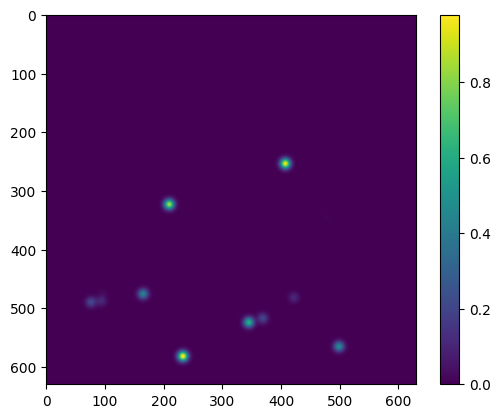

In [6]:
plt.imshow(mask[0, 1, 92, :, :])
plt.colorbar()

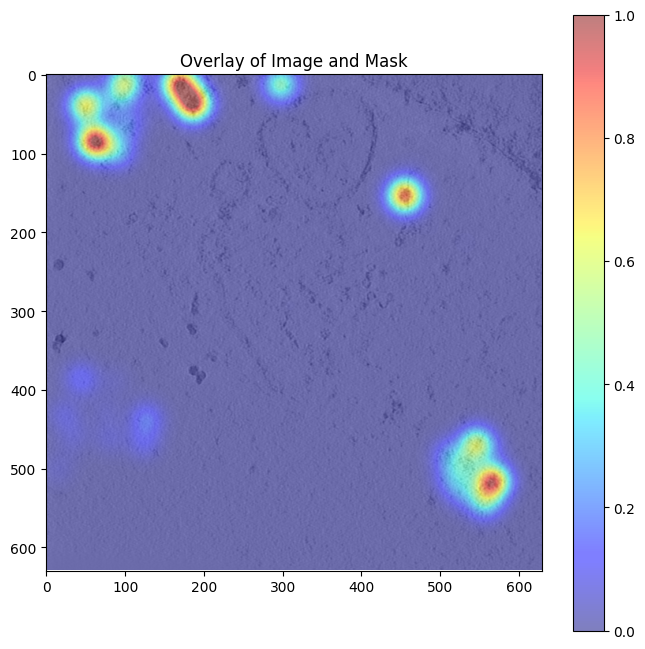

In [7]:
# 重ねて表示
n = 34
x =4
plt.figure(figsize=(8, 8))
plt.imshow(image[n,:,:], cmap='gray', alpha=0.7)  # 元画像を背景として表示
plt.imshow(mask[0,x,n,:,:], cmap='jet', alpha=0.5)  # マスクを透明度0.5で重ねる
plt.colorbar()
plt.title("Overlay of Image and Mask")
plt.show()

In [42]:
def jensen_shannon_divergence_loss(logits, mask, eps=1e-8):
    """
    logits: (B, 7, D, H, W) - ネットワーク出力 (生のロジット)
    mask:   (B, 7, D, H, W) - 連続値のラベル(確率分布を想定)
    eps:    log(0) 回避のための小さい値

    1) Q = softmax(logits, dim=1)
    2) P = mask を [eps,1] にクランプして確率分布とみなす
    3) M = 0.5*(P + Q)
    4) KL(P||M) = ∑ P * log(P/M) をチャネル方向で合計
    5) JS = 0.5*(KL(P||M) + KL(Q||M))
    6) 全ボクセル平均
    """
    mask = F.softmax(mask, dim=1)  # ラベルを確率分布に変換
    # 1) ネットワーク予測確率 Q
    Q = F.softmax(logits, dim=1).clamp(min=eps, max=1.0)  # (B,7,D,H,W)
    # 2) ラベル分布 P
    P = mask.clamp(min=eps, max=1.0)                     # (B,7,D,H,W)
    # 3) 中間分布 M
    M = 0.5 * (P + Q)

    # 4) KL(P||M), KL(Q||M) をチャネル方向 (dim=1) で合計
    KL_PM = (P * (torch.log(P) - torch.log(M))).sum(dim=1)  # (B,D,H,W)
    KL_QM = (Q * (torch.log(Q) - torch.log(M))).sum(dim=1)

    # 5) JS = 0.5 * KL(P||M) + 0.5 * KL(Q||M)
    JS = 0.5 * KL_PM + 0.5 * KL_QM

    # 6) 全ボクセルで平均 (B,D,H,W 方向)
    loss = JS.mean()
    return loss

In [59]:
loss = jensen_shannon_divergence_loss(logit, F.softmax(mask, dim=1))
print(f"JS Loss: {loss.item()}")
loss = jensen_shannon_divergence_loss(mask, F.softmax(mask, dim=1))
print(f"JS Loss: {loss.item()}")

JS Loss: 0.0018740142618460956
JS Loss: 0.0


In [15]:
mask.shape

torch.Size([1, 7, 184, 630, 630])

In [58]:
for i in range(7):
    x = mask[0, i, 92, 100, 100]
    print("x,i", x,i)
mask_softmax = F.softmax(mask, dim=1)
for i in range(7):
    x = mask_softmax[0, i, 92, 100, 100]  # 例として位置 (92, 100, 100) の値を確認
    print(f"x (チャネル {i} の値): {x:.4f}")

x,i tensor(0.0396) 0
x,i tensor(5.7565e-37) 1
x,i tensor(3.0752e-35) 2
x,i tensor(3.6294e-19) 3
x,i tensor(0.9603) 4
x,i tensor(5.3797e-05) 5
x,i tensor(0.) 6
x (チャネル 0 の値): 0.1202
x (チャネル 1 の値): 0.1156
x (チャネル 2 の値): 0.1156
x (チャネル 3 の値): 0.1156
x (チャネル 4 の値): 0.3019
x (チャネル 5 の値): 0.1156
x (チャネル 6 の値): 0.1156


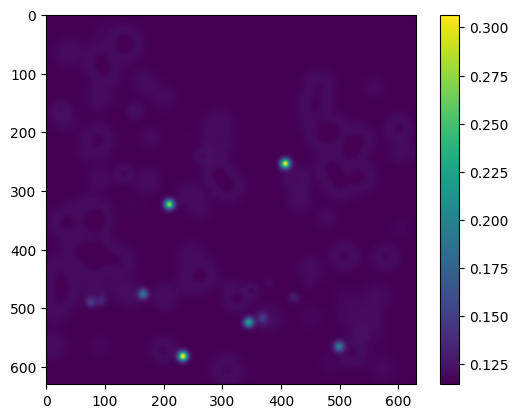

In [60]:
Q = F.softmax(mask, dim=1).clamp(min=1e-8, max=1.0)
plt.imshow(Q[0, 1, 92, :, :])
plt.colorbar()

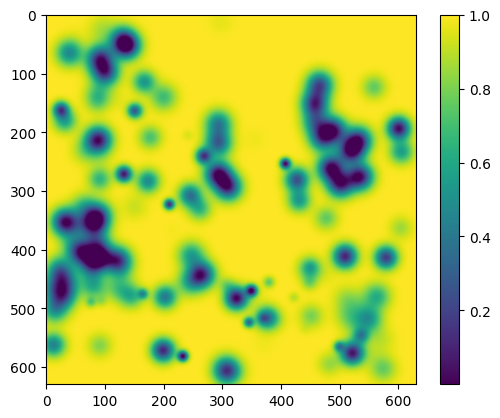

In [35]:
P = mask.clamp(min=1e-8, max=1.0)
plt.imshow(P[0, 0, 92, :, :])
plt.colorbar()